# Insights from a Black Swan Event Monte Carlo Simulation on International Flight Numbers

## Executive Summary

A Black Swan Monte Carlo experiment was performed on international flight data to see how removing random airports, cities and countries would affect overall flight numbers and what information would emerge from the data. Firstly, data was obtained from OpenFlights and cleaned. Following this exploratory data analysis was performed, some of the key insights were as follows:

- Airports and cities are heavily clustered under 2000 flights. Countries have a more even distribution, with most under approximately 3000.
- In each category it appears that there is one to three outliers in each category, the US appears in the outliers in all three.
- All of the top cities are in the top 10 countries except for Istanbul.

Following this, a Monte Carlo experiment was performed on all three categories, yielding the following insights:

- Countries bottomed out just below 50 events with quite a wide distribution between minimum and maximum.
- Initially airports and cities were closely connected with overlapping values. However, after approximately 200 events, the two diverged with a small but stable difference.


## Introduction

As a result of the COVID-19 pandemic, international flights have suffered a substantial drop with numerous travel bans and lockdowns in place. With this in mind, understanding how pronounced the downward spiral effect could be will give key decision makers an indicator of what they should expect. To do this, a Black Swan Monte Carlo simulator will be used to show the likely impact this could have on the number of international flights. A Monte Carlo simulator is a model which repeatedly performs a set simulation a number of times in which specific events take place. The data from this is used to show what is likely to happen if a particular strategy is used. In this context, the Monte Carlo simulator will have specified number of black swan events in which a specified number of random 'nodes' (for example airports) will be removed.
This analysis will involve obtaining and cleaning data, performing exploratory data analysis, running a Black Swan Monte Carlo simulator and drawing insights from the resulting data. A Black Swan event is a (seemingly) unexpected large-scale event which actors are forced to react to, for example the 2008 financial crash.

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import networkx as nx
import random

## Creating dataset and data cleaning

In [2]:
r_columns = ['source_airport','destination_airport','stops']
l_columns = ['source_name', 'source_city','source_country','source_airport']

df_routes = pd.read_csv('https://raw.githubusercontent.com/jpatokal/openflights/master/data/routes.dat', header=None, usecols=[2,4,7], names=r_columns)
df_locs = pd.read_csv('https://raw.githubusercontent.com/jpatokal/openflights/master/data/airports.dat', header=None, usecols=[1, 2,3,4], names=l_columns)
df_routes = df_routes.loc[df_routes['stops'] == 0]
df_routes = df_routes.drop('stops', axis=1)
df_source = df_routes.merge(df_locs, how='left')
df_locs =df_locs.rename(columns={"source_name":"destination_name","source_airport":"destination_airport","source_city":"destination_city","source_country":"destination_country"})
df = df_source.merge(df_locs, how='left')
df

,source_airport,destination_airport,source_name,source_city,source_country,destination_name,destination_city,destination_country
0,AER,KZN,Sochi International Airport,Sochi,Russia,Kazan International Airport,Kazan,Russia
1,ASF,KZN,Astrakhan Airport,Astrakhan,Russia,Kazan International Airport,Kazan,Russia
2,ASF,MRV,Astrakhan Airport,Astrakhan,Russia,Mineralnyye Vody Airport,Mineralnye Vody,Russia
3,CEK,KZN,Chelyabinsk Balandino Airport,Chelyabinsk,Russia,Kazan International Airport,Kazan,Russia
4,CEK,OVB,Chelyabinsk Balandino Airport,Chelyabinsk,Russia,Tolmachevo Airport,Novosibirsk,Russia
...,...,...,...,...,...,...,...,...
67647,WYA,ADL,Whyalla Airport,Whyalla,Australia,Adelaide International Airport,Adelaide,Australia
67648,DME,FRU,Domodedovo International Airport,Moscow,Russia,Manas International Airport,Bishkek,Kyrgyzstan
67649,FRU,DME,Manas International Airport,Bishkek,Kyrgyzstan,Domodedovo International Airport,Moscow,Russia
67650,FRU,OSS,Manas International Airport,Bishkek,Kyrgyzstan,Osh Airport,Osh,Kyrgyzstan


In [3]:
df_nan = df[df.isnull().any(axis=1)]
print('Amount of NaN values:', len(df_nan))
print('Percentage of all values:', (len(df_nan)/len(df))*100)


Amount of NaN values: 733
Percentage of all values: 1.0834860757996807


Due to the low amount of missing data and the complexity in manually entering all of the relevant information, the missing values will be removed.

In [4]:
df = df.dropna()
df

,source_airport,destination_airport,source_name,source_city,source_country,destination_name,destination_city,destination_country
0,AER,KZN,Sochi International Airport,Sochi,Russia,Kazan International Airport,Kazan,Russia
1,ASF,KZN,Astrakhan Airport,Astrakhan,Russia,Kazan International Airport,Kazan,Russia
2,ASF,MRV,Astrakhan Airport,Astrakhan,Russia,Mineralnyye Vody Airport,Mineralnye Vody,Russia
3,CEK,KZN,Chelyabinsk Balandino Airport,Chelyabinsk,Russia,Kazan International Airport,Kazan,Russia
4,CEK,OVB,Chelyabinsk Balandino Airport,Chelyabinsk,Russia,Tolmachevo Airport,Novosibirsk,Russia
...,...,...,...,...,...,...,...,...
67647,WYA,ADL,Whyalla Airport,Whyalla,Australia,Adelaide International Airport,Adelaide,Australia
67648,DME,FRU,Domodedovo International Airport,Moscow,Russia,Manas International Airport,Bishkek,Kyrgyzstan
67649,FRU,DME,Manas International Airport,Bishkek,Kyrgyzstan,Domodedovo International Airport,Moscow,Russia
67650,FRU,OSS,Manas International Airport,Bishkek,Kyrgyzstan,Osh Airport,Osh,Kyrgyzstan


In [5]:
s_airport = df['source_airport'].tolist()
s_city = df['source_city'].tolist()
s_country = df['source_country'].tolist()
d_airport = df['destination_airport'].tolist()
d_city = df['destination_city'].tolist()
d_country = df['destination_country'].tolist()

## Data exploration

To attempt to gain an insight into how the model may differ between the three different categories, a scatter diagram of all elements will be produced. Following this, the top 10 for each category will be shown. From these, insights will be drawn.

In [6]:
df_airport = pd.DataFrame()
df_airport['source'] = df['source_airport'].value_counts()
df_airport['destination'] = df['destination_airport'].value_counts()


df_city = pd.DataFrame()
df_city['source'] = df['source_city'].value_counts()
df_city['destination'] = df['destination_city'].value_counts()


df_country = pd.DataFrame()
df_country['source'] = df['source_country'].value_counts()
df_country['destination'] = df['destination_country'].value_counts()


df_exp = pd.concat([df_airport, df_city, df_country], keys=['1', '2', '3'])

df_exp=df_exp.reset_index(level=0)
df_exp=df_exp.rename(columns={'level_0':'type'})
df_exp['type'].replace({'1': 'airport', '2': 'city', '3':'country'}, inplace=True)

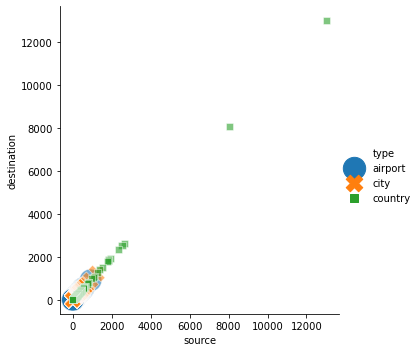

In [24]:
sns.relplot(data=df_exp, x='source', y='destination', hue='type', style='type', sizes=(50, 500), alpha=0.6 , size='type')

In [8]:
display(df_airport.head(10))
display(df_city.head(10))
display(df_country.head(10))

,source,destination
ATL,915,911.0
ORD,558,550.0
LHR,527,524.0
PEK,525,525.0
CDG,524,517.0
FRA,497,493.0
LAX,489,497.0
DFW,469,467.0
JFK,456,455.0
AMS,453,450.0


,source,destination
London,1232,1224.0
Atlanta,915,911.0
Paris,724,719.0
Chicago,697,682.0
New York,614,613.0
Moscow,608,607.0
Shanghai,606,611.0
Beijing,605,605.0
Istanbul,501,504.0
Frankfurt,497,493.0


,source,destination
United States,13015,13010.0
China,8069,8069.0
United Kingdom,2663,2637.0
Spain,2530,2533.0
Germany,2352,2336.0
France,1926,1922.0
Canada,1847,1856.0
Russia,1839,1843.0
Italy,1775,1779.0
India,1506,1503.0


Insights:
- Airports and cities are heavily clustered under 2000 flights. Countries have a more even distribution, with most under approximately 3000.
- In each category it appears that there is one to three outliers in each category, the US appears in the outliers in all three.
- All of the top cities are in the top 10 countries except for Istanbul.
- Many of the top countries are located in or close to Europe.
- Most of the top cities are in the US.
This would suggest countries are likely to descend very quickly in comparison with the others, showing a sudden drop when one of the outliers is removed. Airports and cities are likely to be closely linked with sudden drops when specific hubs are removed.


# Model

The network used is a multi-directional graph, allowing for the number of flights to be calculated and in which direction, allowing the number and direction of flights to be included.
The simplest model the graph can pass through is MC_model which allows the user to specify the following:

- Network type ('airport', 'city', 'country')
- No. of simulations (integer)
- No. of events (integer)
- No. of node removals (integer)

The next model is all_MC_Models which allows the user to specify the same parameters as MC_Model (excluding types) and returns a line graph. For readability, the mean, maximum value and minimum values are shown for each type instead of all values. This model also uses model_regenerate which deletes and rebuilds the network so the simulation can be rerun.
Firstly, the functions will be created, then a small version of the MC_Model with unedited results will be run. An unedited line chart will be shown, followed by a min, max and mean line chart. This will allow the reader to see the difference between the benefits of the min, max and mean line chart instead of showing a line for each simulation. After this, all_MC_Models will be run and finally conclusions will be drawn.


In [9]:
MDiG = nx.MultiDiGraph()

def MC_Model(network, network_type, simulations, events, less_nodes):
    
    split_edge_numbers = []
    df_results = pd.DataFrame(columns=range(events+1))
    
    for num in range(simulations):
        model_regenerate(network, network_type)
        nodes_removed = [0]
        edge_num = []
        edge_num.append(len(network.edges()))
        
        for num in range(events):
            if len(network.nodes()) <= less_nodes: 
                edge_num.append(0)
                continue
            
            nodes_removed.append(less_nodes+nodes_removed[-1])
            for node in range(less_nodes):
                network.remove_node(random.choice([item for item in network.nodes()] ))
                
            edge_num.append(len(network.edges()))
        split_edge_numbers.append(edge_num)
        
    for num in range(len(split_edge_numbers)):
        df_results.loc[num] = split_edge_numbers[num]
        
    return df_results    

In [10]:
def model_regenerate(network, network_type):
    network.remove_nodes_from([item for item in network.nodes()])
    
    if network_type == 'airport': 
        for item in range(len(s_airport)): 
            network.add_edge(s_airport[item], d_airport[item])
    if network_type == 'city': 
        for item in range(len(s_city)):
            network.add_edge(s_city[item], d_city[item])
    if network_type == 'country':
        for item in range(len(s_country)): 
            network.add_edge(s_country[item],d_country[item])
    return network

In [19]:
def all_MC_Models(simulations, events, less_nodes, save=0):
    
    df_airport = MC_Model(MDiG,'airport', simulations, events, less_nodes)
    df_city = MC_Model(MDiG,'city', simulations, events, less_nodes)
    df_country = MC_Model(MDiG,'country', simulations, events, less_nodes)
    
    a_min = plt.plot(df_airport.min(), linewidth=1.0, color='red', alpha=0.7)
    a_mean = plt.plot(df_airport.mean(), linewidth=2.0, color='red', alpha=0.7, label='Airport')
    a_max = plt.plot(df_airport.max(), linewidth=1.0, color='red', alpha=0.7)
    
    ci_min = plt.plot(df_city.min(), linewidth=1.0, color='blue', alpha=0.7)
    ci_mean = plt.plot(df_city.mean(), linewidth=2.0, color='blue', alpha=0.7, label='City')
    ci_max = plt.plot(df_city.max(), linewidth=1.0, color='blue', alpha=0.7)
    
    co_min = plt.plot(df_country.min(), linewidth=1.0, color='yellow', alpha=0.7)
    co_mean = plt.plot(df_country.mean(), linewidth=2.0, color='yellow', alpha=0.7, label='Country')
    co_max = plt.plot(df_country.max(), linewidth=1.0, color='yellow', alpha=0.7)

    plt.xlabel('Events')
    plt.ylabel('Number of Flights')
    plt.title(f'Impact of Black Swan Events on Global Flight Numbers \n {simulations} Simulations with {events} Black Swan Events')
    plt.legend(frameon=False, title='Legend')
    plt.gca().spines['top'].set_visible(False)
    plt.gca().spines['right'].set_visible(False)
    plt.plot()
    
    if save != 0: 
        plt.savefig(save)

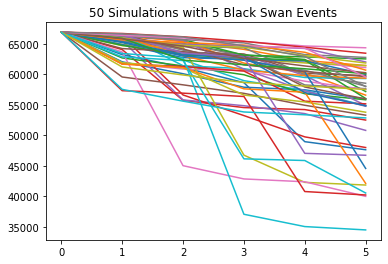

In [12]:
df_results= MC_Model(MDiG, 'country', 50, 5, 5)
df_standard = df_results.T
df_standard.plot.line(legend=False, title='50 Simulations with 5 Black Swan Events')

[]

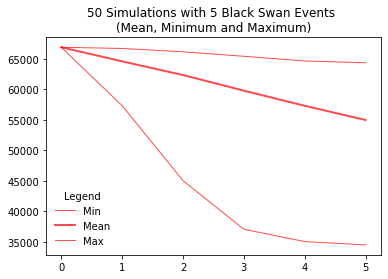

In [13]:
a_min = plt.plot(df_results.min(), linewidth=1.0, color='red', alpha=0.7, label='Min')
a_mean = plt.plot(np.array(df_results.mean()), linewidth=2.0, color='red', alpha=0.7, label='Mean')
a_max = plt.plot(df_results.max(), linewidth=1.0, color='red', alpha=0.7, label='Max')
plt.title('50 Simulations with 5 Black Swan Events \n(Mean, Minimum and Maximum)')
plt.legend(frameon=False, title='Legend')
plt.plot()

As can be seen, the Min, Mean, Max line chart conveys the information but also allows for a more readable comparison.

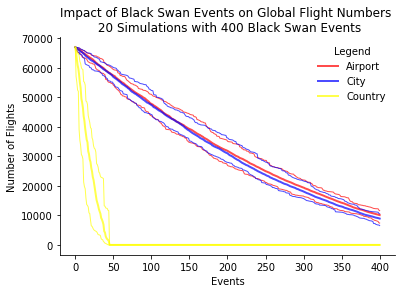

In [22]:
all_MC_Models(20, 400, 5, "mc_model_output.png")


## Observations

- Countries bottomed out just below 50 events with quite a wide distribution between minimum and maximum.
- Initially airports and cities were closely connected with overlapping values. However, after approximately 200 events, the two diverged with a small but stable difference.

It seems that closing multiple countries is likely to have a strong difference on the overall flight number, but there is little difference between airports and cities. Many cities seem to have either few airports with one dominant airport or just one, meaning closing cities is not substantially different (in most cases) to closing airports. Around 1000 airports and cities would need to be closed before many simulations reached approximately half the total number of flights.


## Improvements

Were this experiment to be performed again, the following improvements could be made.

Networks
- A wider range of networks could be created, including airlines (as they could go bankrupt) and continents.
- Smaller networks of key areas (such as the US or Europe) could also be used.

Model
- The model could include more parameters (such as type of graph returned) which may allow more insights into the data.

Data
- A wider range of data could be taken from each network which would give a better understanding how the network breaks down (number of weakly connected nodes for example).
